In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import glob
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from geopy.distance import great_circle
import time

%matplotlib inline

/Users/irarickman/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Executive Summary
Capital Bikeshare is a public bikesharing service founded in 2010, servicing the Washington DC metro area. The Bikeshare system contains about 4500 bikes and over 450 stations. Despite only 4500 bikes in circulation, there are a little over 8000 available spots at each station. Clearly, this can create challenges for Capital Bikeshare. Even at perfect distribution, every station would be slightly over 50% full. Even under normal circumstances, ensuring the right mixture of bikes at each station would be difficult, but given the complexities of population density, commuting, weather, and geography, bikeshare stations can easily be empty, leaving prospective riders without a bike or full, leaving riders without a dock. For my capstone, I have decided to study the effects that empty stations have on neighboring stations, to help determine which stations should be prioritized to refill bikes. 
To study this problem, I’ve gathered data from Capital Bikeshare on every trip taken between September 2010 and March 2017. The data contains the starting location, ending location, start time, end time, and the bike id. Using this data in conjunction with data on the capacity of each station, I was able to engineer a data set of the number of bikes taken in, taken out, moved in, and moved out for each hour between September 2010 and March 2017. To combat the unbalanced dispersion of bikes, Capital Bikeshare uses a practice called ‘rebalancing’ to move bikes from over-crowded stations to under-crowded stations. Using the dataset on the status of each bikeshare station, I created a dataset for each bikeshare station, organized by hour, containing the status of the station (empty, some bikes, full) and the average rate of bikes moving in and out for the 4 nearest stations.

### Approach
For my approach I plan to construct two separate analyses. The first analysis will be a Bayesian inference test of the difference in the average rate of bike movement for neighboring stations for each station, based on whether a station is empty or has bikes. Using this test, I hope to identify which stations have neighboring stations which experience higher rates of bike rental after running out of bikes. The result of this analysis will help identify bikeshare stations to prioritize for rebalancing. The second analysis will be a Markov Chain model of the flow of bikes between stations to model which stations are likeliest to become empty and thus need to be rebalanced. 

### Sorry my notebook is a mess, it will be clean by Thursday though!

## This section below is for getting station data and other system data

In [2]:
url = 'https://gbfs.capitalbikeshare.com/gbfs/en/station_information.json'
r = requests.get(url)
results = r.json()['data']['stations']
stations_list=pd.DataFrame.from_dict(results, orient='columns')
## only regions 41 and 42 are in DC and Virginia, so I'll only use those
dc_va=stations_list[(stations_list.region_id==41)|(stations_list.region_id==42)].copy(deep=True)
dc_stations=set(dc_va.station_id.unique())

In [3]:
stations_list['coords']=[(x,y) for x, y in zip(stations_list.lat, stations_list.lon)]
stations_list.index=stations_list['short_name']
start_time = time.time()
start = stations_list.index
for s in start:
    for e in start:
        stations_list.loc[e,'dist_' +str(s)]=float(great_circle(stations_list.loc[s,'coords'],stations_list.loc[e,'coords']).miles)
end_time = time.time()
print str((end_time - start_time)/60.) + ' minutes to run'

1.33428313335 minutes to run


In [4]:
#making a dictionary of the capacities 
capacities={stat:float(cap) for stat, cap in zip(stations_list.index,stations_list.capacity)}
stations_list.columns.get_loc('coords')
cols=stations_list.columns[12:]
test = stations_list.iloc[:5,:]

In [9]:
start_time =time.time()
for i in stations_list.index:
    count=0
    count_half = 0
    count_35=0
    for val in cols:
        count+=int(stations_list.get_value(i,val)<=.25)
        count_35+=int(stations_list.get_value(i,val)<=.35)
        count_half+=int(stations_list.get_value(i,val)<=.5)
    stations_list.loc[i,'count_.25']=count
    stations_list.loc[i,'count_.35']=count_35
    stations_list.loc[i,'count_.5']=count_half

In [10]:
## the average number of stations within a quarter mile is 2.6, with a median of 2
## the average number of stations within a .35 mile is 4.5, with a median of 4
## the average number of stations within a half mile is 7.8 with a median of 6
## i'm going to use 4
print stations_list['count_.25'].mean(), stations_list['count_.25'].median()
print stations_list['count_.35'].mean(), stations_list['count_.35'].median()
print stations_list['count_.5'].mean(), stations_list['count_.5'].median()

2.65052631579 2.0
4.48210526316 4.0
7.87157894737 6.0


In [5]:
## making a dictionary of the 4 closest stations for each station
start_time =time.time()
closest={}
for x in stations_list.index:
    find = pd.Series(stations_list.loc[x,cols])
    closest[x] = [y[-5:] for y in find.sort_values()[1:5].index]

end_time =time.time()
print str(end_time -start_time) + ' seconds'

0.626090049744 seconds


## This section generates a lot of my data

In [12]:
#getting all my files
files = glob.glob('../Data/*.csv')

In [13]:
# making my make_dates function
def make_dates(df):
    cols = set(df.columns)
    if 'Start date' in cols:
        st= 'Start date'
        end = 'End date'
    elif 'Start time' in cols:
        st= 'Start time'
        end = 'End date'
    df['start']=pd.to_datetime(df[st],infer_datetime_format=True)
    df['end']=pd.to_datetime(df[end],infer_datetime_format=True)
    df['start_year']=df.start.dt.year
    df['end_year']=df.end.dt.year
    df['start_month']=df.start.dt.month
    df['end_month']=df.end.dt.month
    df['start_day']=df.start.dt.day
    df['end_day']=df.end.dt.day
    df['start_hour'] = df.start.dt.hour
    df['start_minute'] = df.start.dt.minute
    df['end_hour'] = df.end.dt.hour
    df['end_minute']=df.end.dt.minute
    df['start_weekday'] = df.start.dt.weekday
    df['end_weekday'] = df.end.dt.weekday
    if 'Duration' in cols:
        dur = 'Duration'
    elif 'Duration (ms)' in cols:
        dur = 'Duration (ms)'
    elif 'Total duration (ms)' in cols:
        dur = 'Total duration (ms)'
    try:
        df['trip_time']=(df[dur].astype(float)/60000).astype(float)
    except ValueError:
        df['trip_time']=0
    df['start']=df.start.map(lambda x: x.strftime('%Y-%m-%d %H'))

In [14]:
# renaming columns
def rename(df):
    cols = set(df.columns)
    df.dropna(axis=0, inplace=True)
    if 'Start station number' not in cols:
        if 'Start station' in cols:
            df['Start station number']= (df['Start station'].str.replace('(Dupont Circle south)','0').astype(str).str.extract(r"\((.*?)\)")).astype(float)
            start_stat = 'Start station number'
        elif 'Start Station' in cols:
            df['Start station number']= (df['Start Station'].str.replace('(Dupont Circle south)','0').astype(str).str.extract(r"\((.*?)\)")).astype(float)
            start_stat = 'Start station number'
    if 'End station number' not in cols:
        if 'End station' in cols:
            df['End station number']= (df['End station'].str.replace('(Dupont Circle south)','0').astype(str).str.extract(r"\((.*?)\)")).astype(float)
            end_stat = 'End station number'
        elif 'End Station' in cols:
            df['End station number']= (df['End Station'].str.replace('(Dupont Circle south)','0').astype(str).str.extract(r"\((.*?)\)")).astype(float)
            end_stat = 'End station number'
    if 'End station number' in cols:
        end_stat = 'End station number'
    new_end = 'end_stat'
    if 'Start station number' in cols:
        start_stat = 'Start station number'
    new_start = 'start_stat'
    if 'Bike number' in cols:
        bike_num = 'Bike number'
    elif 'Bike #' in cols:
        bike_num = 'Bike #'
    elif 'Bike#' in cols:
        bike_num = 'Bike#'
    new_bike = 'bike_id'
    if 'Member Type' in cols:
        mem = 'Member Type'
    elif 'Member type' in cols:
        mem = 'Member type'
    elif 'Account type' in cols:
        mem = 'Account type'
    elif 'Type' in cols:
        mem= 'Type'
    elif 'Subscription type' in cols:
        mem = 'Subscription type'
    elif 'Subscription Type' in cols:
        mem = 'Subscription Type'
    elif 'Subscriber Type' in cols:
        mem = 'Subscriber Type'
    elif 'Bike Key' in cols:
        mem = 'Bike Key'    
    new_mem='type'
    df.rename(columns = {end_stat:new_end, start_stat:new_start, bike_num:new_bike, mem:new_mem},inplace=True)

In [15]:
# generating the hours dataset for each station
def station_hours(df, start_date='', end_date=''):
    '''This function takes in a period of bikeshare data, then pumps out a dicitionary of data frames of the per hour movement 
    of bikes within the station. It also generates new hour periods and trims columns'''
    if start_date=='':
        start_date=df.start.min()
        end_date=df.start.max()
    ix = pd.DatetimeIndex(start=pd.to_datetime(start_date), end=pd.to_datetime(end_date), freq='H')
    hours = pd.DataFrame(ix.map(lambda x: x.strftime('%Y-%m-%d %H')), columns = ['start'])
    stats = {}
    racks = df.start_stat.unique()
    dc_racks = get_dc()
    for rack in dc_racks:
        rack = float(rack)
        try:
            temp=df[(df['start_stat']==rack)|(df['end_stat']==rack)].copy(deep=True)
            temp['moved_in']=temp[temp['start_stat']==rack].moved
            temp['moved_out']=temp[temp['end_stat']==rack].moved
            temp['in']= (temp.end_stat==rack).astype(int)
            temp['out']=(temp.start_stat==rack).astype(int)
            temp_temp = temp.drop(['end_stat', 'start_stat', 'moved'], axis=1)
            temp_grp = temp_temp.groupby(temp_temp['start']).sum().reset_index()
            temp_all = hours.merge(temp_grp, how = 'left', on = 'start')
            temp_all.fillna(0, inplace=True)
            stats[rack]=temp_all.copy(deep=True)
        except TypeError:
            print type(rack), type(df.loc[0,'start_stat']), type(df.loc[0,'end_stat'])
            pass
    return stats

def get_dc():
    url = 'https://gbfs.capitalbikeshare.com/gbfs/en/station_information.json'
    r = requests.get(url)
    results = r.json()['data']['stations']
    stations_list=pd.DataFrame.from_dict(results, orient='columns')
    ## only regions 41 and 42 are in DC and Virginia, so I'll only use those
    dc_va=stations_list[(stations_list.region_id==41)|(stations_list.region_id==42)].copy(deep=True)
    dc_stations=set(dc_va.short_name.unique())
    return dc_stations

In [16]:
# saving each station as a dataframe
def save_stations(data,path):
    '''This function takes in a dictionary of station data frames then saves them to my folder'''
    for station in data.keys():
        data[station].to_csv('../cap_data' + path + '_'+ str(station) + '.csv', index=False)

In [17]:
## defining my cleaning functions

def prev_station(df):
    df['previous']=df.sort_values(['bike_id','start']).groupby('bike_id')['end_stat'].shift(1)
    df['previous'].fillna(df['end_stat'])
    
def moved(df):
    df['moved']=(df['start_stat']!=df['previous']).astype(int)
    
def drop_cols(df):
    cols=set(df.columns)
    if 'Duration' in cols:
        dur = 'Duration'
    elif 'Duration (ms)' in cols:
        dur = 'Duration (ms)'
    elif 'Total duration (ms)' in cols:
        dur = 'Total duration (ms)'
    if 'Start date' in cols:
        st= 'Start date'
        end = 'End date'
    elif 'Start time' in cols:
        st= 'Start time'
        end = 'End date'
    if 'Start Station' in cols:
        st_stat = 'Start Station'
    elif "Start station" in cols:
        st_stat ='Start station'
    if 'End Station' in cols:
        e_stat = 'End Station'
    elif "End station" in cols:
        e_stat ='End station'
    df.drop([dur, st, end, 'end', 'previous','trip_time','bike_id','type', 'start_weekday', 'end_weekday', 'start_minute', 'end_minute', st_stat, e_stat, 'end_year', 'end_month', 'end_day','end_hour', 'start_year', 'start_month', 'start_day', 'start_hour'], axis=1, inplace=True)


In [ ]:
## looping through all the files and converting them, then exporting them
import time
start_time = time.time()
final_stats = get_dc()
final_stations = [float(x) for x in final_stats]
for bike in files:
    print bike
    stats=''
    nm = bike[7:-4]
    bikes = pd.read_csv(bike)
    make_dates(bikes)
    rename(bikes)
    prev_station(bikes)
    moved(bikes)
    drop_cols(bikes)
    stats = station_hours(bikes)
    save_stations(stats, nm)
    
time2 = time.time()
print str((time2 - start_time)/60.) + ' minutes to run'

In [ ]:
# this loop combines all the quarter station data frames into data frames for each station
start_time = time.time()
loop_stats = [str(x) for x in final_stations]
for stat in loop_stats:
    bike_data= glob.glob('../cap_data/*' + stat + '.csv')
    bike_df = pd.DataFrame(columns = pd.read_csv(bike_data[0]).columns)
    for bike_st in bike_data:
        bike_df=bike_df.append(pd.read_csv(bike_st))
    bike_df_1 = bike_df.drop(['station'],axis=1).drop_duplicates()
    bike_df_2 = bike_df_1.groupby('start').sum().reset_index()
    bike_df_2.to_csv('../cap_data/stations/' + stat + '_data.csv', index=False)
time2 = time.time()
print str((time2 - start_time)/60.) + ' minutes to run'

In [7]:
# practicing making grouped cumulative sums
stat_files = glob.glob('../cap_data/stations/*_data.csv')
diff_df=pd.read_csv(stat_files[300])
diff_df['date']=diff_df['start'].apply(lambda x: x.split(' ')[0])
diff_df['hour']=diff_df['start'].apply(lambda x: x.split(' ')[1]).astype(int)
diff_df['group']=diff_df.hour.apply(lambda x: 'am_1' if x<7 else 'am_2' if x<13 else 'pm_1' if x<19 else 'pm_2' )
day_df=diff_df.drop(['start', 'hour','group'], axis=1).groupby('date').sum().reset_index()
per_df=diff_df.drop(['start','hour'], axis=1).groupby(['date', 'group']).sum().reset_index()
day_df['net']=day_df['in']+day_df['moved_in'] - day_df['out']-day_df['moved_out']
per_df['net']=per_df['in']+per_df['moved_in'] - per_df['out']-per_df['moved_out']
day_df['status']=day_df.groupby('date').net.cumsum()
day_cols = list(day_df.columns)
per_df['status']=per_df.groupby('date').net.cumsum()
per_cols= list(per_df.columns)
day_cols.append('station')
per_cols.append('station')
print day_df.tail()
print per_df.tail()

            date     in  moved_in  moved_out   out   net  status
2385  2017-03-27  100.0      51.0       52.0  84.0  15.0    15.0
2386  2017-03-28   89.0      34.0       41.0  71.0  11.0    11.0
2387  2017-03-29   90.0      39.0       42.0  72.0  15.0    15.0
2388  2017-03-30   74.0      37.0       29.0  74.0   8.0     8.0
2389  2017-03-31   27.0      10.0        7.0  24.0   6.0     6.0
            date group    in  moved_in  moved_out   out  net  status
9553  2017-03-30  pm_2  13.0      11.0        5.0  13.0  6.0     8.0
9554  2017-03-31  am_1   0.0       0.0        0.0   2.0 -2.0    -2.0
9555  2017-03-31  am_2   3.0       0.0        0.0   3.0  0.0    -2.0
9556  2017-03-31  pm_1  21.0       8.0        7.0  14.0  8.0     6.0
9557  2017-03-31  pm_2   3.0       2.0        0.0   5.0  0.0     6.0


In [8]:
# making the dataframes for all stations by day and by 6 hour block
start_time=time.time()
count=0
stat_files = glob.glob('../cap_data/stations/*_data.csv')
days_df =pd.DataFrame(columns = day_cols)
pers_df =pd.DataFrame(columns = per_cols)
for st in stat_files:
    d = pd.read_csv(st)
    d['date']=diff_df['start'].apply(lambda x: x.split(' ')[0])
    d['hour']=d['start'].apply(lambda x: x.split(' ')[1]).astype(int)
    d['group']=d.hour.apply(lambda x: 'am_1' if x<7 else 'am_2' if x<13 else 'pm_1' if x<19 else 'pm_2' )
    day=d.drop(['start', 'hour','group'], axis=1).groupby('date').sum().reset_index()
    per=d.drop(['start','hour'], axis=1).groupby(['date', 'group']).sum().reset_index()
    day['net']=day['in']+day['moved_in'] - day['out']-day['moved_out']
    per['net']=per['in']+per['moved_in'] - per['out']-per['moved_out']
    day['status']=day.groupby('date').net.cumsum()
    day['station']=st[-16:-9]
    per['status']=per.groupby('date').net.cumsum()
    day_m=min(per[(per['in']!=0)|(per['out']!=0)|(per['moved_in']!=0)|(per['moved_out']!=0)].index)
    per_m=min(day[(day['in']!=0)|(day['out']!=0)|(day['moved_in']!=0)|(day['moved_out']!=0)].index)
    per['station']=st[-16:-9]
    days_df=days_df.append(day[day_m:])
    pers_df=pers_df.append(per[per_m:])
    count+=1
    if count%10==0:
        print str(count) + ' ' + str((time.time()-start_time)/60.) + ' minutes in'
end_time = time.time()
print str((end_time - start_time)/60.) + ' minutes to run'

10 0.0312509854635 minutes in
20 0.0626602689425 minutes in
30 0.0974544843038 minutes in
40 0.133962349097 minutes in
50 0.173058485985 minutes in
60 0.214985815684 minutes in
70 0.259259001414 minutes in
80 0.305827701092 minutes in
90 0.355476884047 minutes in
100 0.408251901468 minutes in
110 0.464418017864 minutes in
120 0.523521566391 minutes in
130 0.587076151371 minutes in
140 0.659903033574 minutes in
150 0.731680083275 minutes in
160 0.808403166135 minutes in
170 0.886609299978 minutes in
180 0.971607132753 minutes in
190 1.05288760265 minutes in
200 1.13588166634 minutes in
210 1.22159073353 minutes in
220 1.31039191882 minutes in
230 1.40169895093 minutes in
240 1.49643390179 minutes in
250 1.59397953351 minutes in
260 1.69472895066 minutes in
270 1.79719014963 minutes in
280 1.90303733349 minutes in
290 2.01308805148 minutes in
300 2.12640906572 minutes in
310 2.24200591644 minutes in
320 2.36021746794 minutes in
330 2.48054313262 minutes in
340 2.60000481606 minutes in
2.

In [9]:
## making the dataframe of all stations and their top 4 distances
    # need to make the net/6 and net/24 for the hourly rates
pers_df['capacity']=pers_df['station'].apply(lambda x: capacities[str(int(float(x)))])
pers_df['state']=['empty' if x<-y else 'full' if x>y else 'reg' for x,y in zip(pers_df['status'],pers_df['capacity'])]
pers_df.state.value_counts()

reg      2971414
full        3974
empty       3694
Name: state, dtype: int64

In [10]:
days_df['capacity']=days_df['station'].apply(lambda x: capacities[str(int(float(x)))])
days_df['state']=['empty' if x<-y else 'full' if x>y/2 else 'reg' for x,y in zip(days_df['status'],days_df['capacity'])]
days_df.head()

,date,in,moved_in,moved_out,out,net,status,station,capacity,state
20,2010-10-05,2.0,5.0,0.0,6.0,1.0,1.0,31000.0,15.0,reg
21,2010-10-06,1.0,0.0,1.0,1.0,-1.0,-1.0,31000.0,15.0,reg
22,2010-10-07,4.0,2.0,2.0,3.0,1.0,1.0,31000.0,15.0,reg
23,2010-10-08,0.0,0.0,0.0,3.0,-3.0,-3.0,31000.0,15.0,reg
24,2010-10-09,2.0,3.0,2.0,3.0,0.0,0.0,31000.0,15.0,reg


In [11]:
# i'm going to drop observations before stations become active
print pers_df.state.value_counts()
print '\n'
print days_df.state.value_counts()

reg      2971414
full        3974
empty       3694
Name: state, dtype: int64


reg      268659
full       7202
empty       286
Name: state, dtype: int64


In [12]:
# only making top 4 rows for stations with more than 5 empties

In [34]:
days_cts = pd.crosstab(days_df.station, days_df.state)
pers_cts = pd.crosstab(pers_df.station, pers_df.state)
print len(days_cts[days_cts['empty']>=1])
print len(pers_cts[pers_cts['empty']>=1])
day_racks = set([str(x)[:-2] for x in days_cts[days_cts['empty']>=1].index])
per_racks = set([str(x)[:-2] for x in pers_cts[pers_cts['empty']>=1].index])

55
229


In [39]:
day_racks

{'31000',
 '31003',
 '31008',
 '31018',
 '31020',
 '31101',
 '31102',
 '31104',
 '31105',
 '31107',
 '31109',
 '31110',
 '31111',
 '31113',
 '31200',
 '31201',
 '31202',
 '31203',
 '31206',
 '31209',
 '31212',
 '31213',
 '31214',
 '31218',
 '31222',
 '31224',
 '31226',
 '31229',
 '31237',
 '31239',
 '31241',
 '31245',
 '31300',
 '31301',
 '31305',
 '31400',
 '31401',
 '31404',
 '31503',
 '31600',
 '31602',
 '31603',
 '31604',
 '31605',
 '31606',
 '31608',
 '31610',
 '31613',
 '31616',
 '31618',
 '31623',
 '31624',
 '31700',
 '31801',
 '31802'}

In [43]:
## mixing the top 4 stations for each
start_time=time.time()
count=0
model_days = pd.DataFrame(columns =['station', 'state', 'avg_rate'])
model_pers = pd.DataFrame(columns =['station', 'state', 'avg_rate'])
for fin in closest.keys():
    p=0
    d=0
    rack = fin + '.0'
    if fin in day_racks:
        temp_days = days_df[days_df['station']==rack][['date','state']]
        d=1
    if fin in per_racks:
        temp_pers = pers_df[pers_df['station']==rack][['date','group','state']]
        p=1
    if (p==0) & (d==0):
    else:
        if d==1:
            c = 1
            for s in closest[fin]:
                r = s + '.0'
                top_d = days_df[days_df['station']==r][['date','net']]
                top_d['rate' + str(c)]=top_d['net']/24.
                temp_days = temp_days.merge(top_d[['date','rate' + str(c)]], on ='date', how = 'left')
                c+=1
            temp_days['avg_rate']=temp_days[['rate1', 'rate2', 'rate3', 'rate4']].mean(axis=1)
            temp_days['station']=rack
            fin_days = temp_days[['station', 'state', 'avg_rate']]
            model_days=model_days.append(fin_days)
        if p==1:
            c = 1
            for s in closest[fin]:
                r = s + '.0'
                top_p = pers_df[pers_df['station']==r][['date','group','net']]
                top_p['rate' + str(c)]=top_p['net']/6.
                temp_pers = temp_pers.merge(top_p[['date','group','rate' + str(c)]], on =['date','group'], how = 'left')
                c+=1
            temp_pers['avg_rate']=temp_pers[['rate1', 'rate2', 'rate3', 'rate4']].mean(axis=1)
            temp_pers['station']=rack
            fin_pers = temp_pers[['station', 'state', 'avg_rate']]
            model_pers=model_pers.append(fin_pers)
        count+=1
        if count%50==0:
            print str(count) + ' - ' + str((time.time()-start_time)/60.) + ' minutes in'
end_time = time.time()
print str((end_time - start_time)/60.) + ' minutes to run'

31292
31293
31620
31298
31299
31913
31912
31910
31916
31915
31914
31918
31279
31276
31277
31274
31275
31272
31273
31271
32013
32012
32011
32010
32017
32016
32015
32014
32019
32018
31250
31240
31009
31005
31002
31621
31076
31306
31302
31097
31094
31098
31099
32057
32056
32055
32054
32053
32052
32051
32050
32059
32058
31228
31287
31284
31283
31126
31127
31124
31122
31123
50 - 1.16264561812 minutes in
31232
31233
31230
31231
31236
31235
31238
31041
31043
31042
31045
31044
31048
31518
31128
31516
31052
31908
31909
31904
31906
31907
31900
31903
32224
32225
32220
32221
32222
32223
31505
31248
31243
31242
31246
32008
32009
32004
32005
32006
32007
32000
32001
32002
32003
31644
31643
31642
31014
31015
31011
32219
32218
32215
32214
32217
32216
32211
32210
32213
32212
32040
32041
32042
32043
32044
32045
32046
32047
32048
32049
31291
31294
31295
31296
31297
100 - 2.34856476784 minutes in
32035
32034
32037
32036
32031
32030
32033
32032
32039
32038
31208
31205
31812
31811
31507
31508
31712
31413
314

In [44]:
print model_days.isnull().sum()
print '\n'
print model_pers.isnull().sum()
print model_days.shape, model_pers.shape
print model_days.state.value_counts()
print model_pers.state.value_counts()

station         0
state           0
avg_rate    11591
dtype: int64


station        0
state          0
avg_rate    7445
dtype: int64
(117623, 3) (1996748, 3)
reg      114383
full       2954
empty       286
Name: state, dtype: int64
reg      1991766
empty       3694
full        1288
Name: state, dtype: int64


In [45]:
## dropping nulls
model_days_1=model_days.dropna()
print model_days_1.isnull().sum()
model_pers_1 = model_pers.dropna()
print model_pers_1.isnull().sum()

station     0
state       0
avg_rate    0
dtype: int64
station     0
state       0
avg_rate    0
dtype: int64


In [46]:
# exporting to csv just in case
model_days_1.to_csv('../cap_data/model_data/model_days.csv',index=False)
model_pers_1.to_csv('../cap_data/model_data/periods_days.csv',index=False)

In [47]:
days_model=pd.read_csv('../cap_data/model_data/model_days.csv')
days_model.shape

(106032, 3)

In [76]:
pers_model = pd.read_csv('../cap_data/model_data/periods_days.csv')
pers_model.shape

(1989303, 3)

In [49]:
pd.crosstab(pers_model.station, pers_model.state)

state,empty,full,reg
station,,,
31000.0,4,0,9549
31001.0,13,1,9539
31003.0,14,2,9537
31004.0,34,1,9518
31006.0,6,0,9547
31007.0,1,0,9552
31008.0,28,2,9522
31010.0,15,3,9535
31012.0,4,2,9547


In [85]:
## IT'S BAYESIAN TIME!!
import pymc3 as pm
## setting up the model function
def mc(data,rack):
    empty = data[(data['state']=='empty')&(data['station']==rack)].avg_rate.values
    reg = data[(data['state']=='reg')&(data['station']==rack)].avg_rate.values
    p_mean = data[data['station']==rack].avg_rate.mean()
    p_std = data[data['station']==rack].avg_rate.std()
    std_prior_lower = 0.1
    std_prior_upper = 10.0
    with pm.Model() as model:

        empty_mean = pm.Normal('empty_mean', p_mean, sd=p_std)
        reg_mean = pm.Normal('reg_mean',  p_mean, sd=p_std)
        empty_std = pm.Uniform('empty_std', lower=std_prior_lower, upper=std_prior_upper)
        reg_std = pm.Uniform('reg_std', lower=std_prior_lower, upper=std_prior_upper)
        e_post= pm.Normal('E_rate', mu=empty_mean, sd=empty_std, observed=empty)
        reg_post = pm.Normal('Reg_rate', mu=reg_mean, sd=reg_std, observed=reg)
        diff_of_means = pm.Deterministic('difference of means', empty_mean - reg_mean)
        diff_of_stds = pm.Deterministic('difference of stds', empty_std - reg_std)
        trace = pm.sample(10000, njobs=4)
    return pm.df_summary(trace[3000:],varnames=['difference of means', 'difference of stds'])

In [ ]:
start_time=time.time()
test= mc(pers_model,31071.0)

end_time = time.time()
print str((end_time - start_time)/60.) + ' minutes to run'


Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = -2,041.3:  12%|█▏        | 23207/200000 [00:04<00:30, 5833.89it/s]
Convergence archived at 23600
Interrupted at 23,600 [11%]: Average Loss = 4,571


In [54]:
test.index

Index([u'difference of means', u'difference of stds'], dtype='object')

In [77]:
days_bayes_df = pd.DataFrame(columns = ['station','mean_mean', 'mean_std', 'mean_mc_error', 'mean_2.5', 'mean_97.5','std_mean', 'std_std', 'std_mc_error', 'std_2.5', 'std_97.5'])
rw = len(test_df)
test_df.loc[rw,'station']=311
test_df.loc[rw,1:6]=[x for x in test.loc['difference of means']]
test_df.loc[rw,6:]=[y for y in test.loc['difference of stds']]
#test_df.loc[len(test_df)]=test.iloc[1,:]
test_df

,station,mean_mean,mean_std,mean_mc_error,mean_2.5,mean_97.5,std_mean,std_std,std_mc_error,std_2.5,std_97.5
0,311,0.000376732,0.080423,0.000333467,-0.158385,0.155453,0.0118422,4.03261,0.0224794,-7.91518,7.40799


In [54]:
racks_d = set(days_model.station)
print len(racks_d)
racks_p = set(pers_model.station)
print len(racks_p)
days_bayes_df = pd.DataFrame(columns = ['station','mean_mean', 'mean_std', 'mean_mc_error', 'mean_2.5', 'mean_97.5','std_mean', 'std_std', 'std_mc_error', 'std_2.5', 'std_97.5'])
periods_bayes_df = pd.DataFrame(columns = ['station','mean_mean', 'mean_std', 'mean_mc_error', 'mean_2.5', 'mean_97.5','std_mean', 'std_std', 'std_mc_error', 'std_2.5', 'std_97.5'])

53
229


In [55]:
start_time=time.time()
count=0
for d in racks_d:
    temp = mc(days_model, d)
    rw =len(days_bayes_df)
    days_bayes_df.loc[rw,'station']=d
    days_bayes_df.loc[rw,1:6]=[x for x in temp.loc['difference of means']]
    days_bayes_df.loc[rw,6:]=[x for x in temp.loc['difference of stds']]
    count+=1
    if count%10==0:
        days_bayes_df.to_csv(str(count) + ' stations.csv', index=False)
        end_time = time.time()
        print str(count) + ' -  after ' + str((end_time - start_time)/60.) + ' minutes'
end_time = time.time()
print str((end_time - start_time)/60.) + ' minutes to run'

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 199.17:  13%|█▎        | 26888/200000 [00:02<00:19, 8710.28it/s] 
Convergence archived at 27400
Interrupted at 27,400 [13%]: Average Loss = 1,447.4
 95%|█████████▌| 9993/10500 [00:30<00:02, 238.79it/s]/Users/irarickman/anaconda2/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 1 contains 1 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 10500/10500 [00:32<00:00, 320.32it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = -1,328.6:  11%|█         | 22352/200000 [00:02<00:20, 8548.74it/s]
Convergence archived at 22400
Interrupted at 22,400 [11%]: Average Loss = 1,199.1
100%|██████████| 10500/10500 [00:45<00:00, 232.86it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = -1,747.9:  11%|█         | 22122/200000 [00:02<0

10 -  after 10.2419095 minutes


Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = -4.1132:  11%|█▏        | 22775/200000 [00:02<00:15, 11565.18it/s]
Convergence archived at 23300
Interrupted at 23,300 [11%]: Average Loss = 372.83
100%|██████████| 10500/10500 [00:26<00:00, 403.73it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = -2,936.4:  21%|██        | 41523/200000 [00:04<00:16, 9756.68it/s]
Convergence archived at 42300
Interrupted at 42,300 [21%]: Average Loss = -938.2
100%|██████████| 10500/10500 [00:26<00:00, 390.59it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = -2,908.8:  21%|██        | 41861/200000 [00:04<00:17, 9272.24it/s] 
Convergence archived at 42300
Interrupted at 42,300 [21%]: Average Loss = -929.15
100%|██████████| 10500/10500 [00:35<00:00, 293.26it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = -203.5:  10%|█         | 20997/200000 [00:02<00:20, 8742.65it/s] 
Convergence

20 -  after 20.1204869151 minutes


Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = -279.98:  10%|█         | 20692/200000 [00:01<00:16, 10885.21it/s]
Convergence archived at 21500
Interrupted at 21,500 [10%]: Average Loss = 345.28
100%|██████████| 10500/10500 [00:28<00:00, 369.37it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = -369.42:  14%|█▎        | 27196/200000 [00:03<00:20, 8606.51it/s]
Convergence archived at 27900
Interrupted at 27,900 [13%]: Average Loss = 1,110.2
100%|██████████| 10500/10500 [00:31<00:00, 330.15it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = -219.8:  11%|█         | 21193/200000 [00:01<00:15, 11339.69it/s] 
Convergence archived at 22100
Interrupted at 22,100 [11%]: Average Loss = 398.54
100%|██████████| 10500/10500 [00:25<00:00, 410.83it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = -2,905.9:  21%|██        | 42138/200000 [00:04<00:17, 9224.76it/s]
Convergence 

30 -  after 33.4689278841 minutes


Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = -958.07:  14%|█▎        | 27455/200000 [00:03<00:32, 5348.73it/s]
Convergence archived at 27900
Interrupted at 27,900 [13%]: Average Loss = 792.47
100%|██████████| 10500/10500 [00:28<00:00, 365.42it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = -3,006.3:  21%|██        | 41591/200000 [00:04<00:15, 9982.62it/s]
Convergence archived at 42300
Interrupted at 42,300 [21%]: Average Loss = -1,001.2
100%|██████████| 10500/10500 [00:29<00:00, 359.02it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = -1,734.1:  10%|▉         | 19283/200000 [00:02<00:19, 9214.30it/s]
Convergence archived at 19400
Interrupted at 19,400 [9%]: Average Loss = 1,351.5
100%|██████████| 10500/10500 [02:41<00:00, 62.08it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = -1,294:  14%|█▍        | 27687/200000 [00:03<00:23, 7399.88it/s]  
Convergence 

40 -  after 44.858695066 minutes


Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = -184.55:  11%|█         | 21717/200000 [00:02<00:20, 8873.99it/s]
Convergence archived at 22400
Interrupted at 22,400 [11%]: Average Loss = 1,552
100%|██████████| 10500/10500 [00:41<00:00, 253.15it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = -2,376.7:  15%|█▍        | 29899/200000 [00:03<00:19, 8606.03it/s]
Convergence archived at 30200
Interrupted at 30,200 [15%]: Average Loss = 41.575
100%|██████████| 10500/10500 [00:48<00:00, 215.77it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = -1,104.9:  11%|█         | 21499/200000 [00:02<00:19, 9326.69it/s]
Convergence archived at 22400
Interrupted at 22,400 [11%]: Average Loss = 1,201.4
100%|██████████| 10500/10500 [00:50<00:00, 127.32it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = -1,306.4:  11%|█         | 21890/200000 [00:02<00:20, 8518.65it/s]
Convergence a

50 -  after 57.5774330815 minutes


Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = -1,366.5:  14%|█▍        | 27817/200000 [00:03<00:21, 8129.61it/s]
Convergence archived at 28600
Interrupted at 28,600 [14%]: Average Loss = 582.45
100%|██████████| 10500/10500 [00:32<00:00, 323.46it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = -712.83:  12%|█▏        | 24261/200000 [00:02<00:18, 9360.44it/s]
Convergence archived at 25100
Interrupted at 25,100 [12%]: Average Loss = 1,089.3
100%|██████████| 10500/10500 [00:29<00:00, 357.98it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = -864.14:  11%|█         | 22277/200000 [00:02<00:22, 7922.94it/s]
Convergence archived at 22400
Interrupted at 22,400 [11%]: Average Loss = 1,332.8
100%|██████████| 10500/10500 [00:42<00:00, 247.78it/s]


60.6177325169 minutes to run


In [56]:
days_bayes_df.to_csv('final_bayes_model_stations_9-6-1500.csv', index=False)

In [83]:
done = pd.read_csv('148_periods_stations.csv')
done_stats = set(done.station)
to_do_p = [x for x in racks_p if x not in done_stats]
len(to_do_p)

80

excludes 0 from 95% HPD so we can conclude it's different

In [ ]:
## running on the period data set
start_time=time.time()
count=0
for p in racks_p:
    temp = mc(pers_model, p)
    rw =len(periods_bayes_df)
    periods_bayes_df.loc[rw,'station']=p
    periods_bayes_df.loc[rw,1:6]=[x for x in temp.loc['difference of means']]
    periods_bayes_df.loc[rw,6:]=[x for x in temp.loc['difference of stds']]
    count+=1
    if count%10==0:
        periods_bayes_df.to_csv(str(count) + ' _periods_stations.csv', index=False)
        end_time = time.time()
        print str(count) + ' -  after ' + str((end_time - start_time)/60.) + ' minutes'
end_time = time.time()
print str((end_time - start_time)/60.) + ' minutes to run'

In [87]:
## running on the period data set for the remaining ones after the first run through
periods_bayes_df = pd.DataFrame(columns = ['station','mean_mean', 'mean_std', 'mean_mc_error', 'mean_2.5', 'mean_97.5','std_mean', 'std_std', 'std_mc_error', 'std_2.5', 'std_97.5'])
start_time=time.time()
count=0
for p in to_do_p:
    print p
    temp = mc(pers_model, p)
    rw =len(periods_bayes_df)
    periods_bayes_df.loc[rw,'station']=p
    periods_bayes_df.loc[rw,1:6]=[x for x in temp.loc['difference of means']]
    periods_bayes_df.loc[rw,6:]=[x for x in temp.loc['difference of stds']]
    count+=1
    if count%10==0:
        periods_bayes_df.to_csv(str(count) + ' _periods_addl_stations.csv', index=False)
        end_time = time.time()
        print str(count) + ' -  after ' + str((end_time - start_time)/60.) + ' minutes'
end_time = time.time()
print str((end_time - start_time)/60.) + ' minutes to run'

INFO (theano.gof.compilelock): Refreshing lock /Users/irarickman/.theano/compiledir_Darwin-16.7.0-x86_64-i386-64bit-i386-2.7.13-64/lock_dir/lock


31073.0


AssertionError: 

In [71]:
#periods_bayes_df.to_csv('137_periods_stations.csv',index=False)
#periods_bayes_df.to_csv('148_periods_stations.csv',index=False)


In [67]:
test.iloc[1,:]

capacity                                                                   11
eightd_has_key_dispenser                                                False
eightd_station_services                                                   NaN
lat                                                                   38.8573
lon                                                                  -77.0533
name                                                          18th & Eads St.
region_id                                                                  41
rental_methods                                              [KEY, CREDITCARD]
rental_url                  http://app.capitalbikeshare.com/vIiR/zVsfTIsOT...
short_name                                                              31001
station_id                                                                  2
coords                                                  (38.85725, -77.05332)
dist_31000                                                      

## 2016 Data Viz

In [4]:
bikes.shape

(3333786, 10)

In [5]:
bikes.columns

Index([u'Account type', u'Bike number', u'Duration (ms)', u'End date',
       u'End station', u'End station number', u'Member Type', u'Start date',
       u'Start station', u'Start station number'],
      dtype='object')

In [6]:
bikes.head()

,Account type,Bike number,Duration (ms),End date,End station,End station number,Member Type,Start date,Start station,Start station number
0,NaN,W00022,301295,4/1/2016 0:04,1st & Rhode Island Ave NW,31506,Registered,3/31/2016 23:59,11th & S St NW,31280
1,NaN,W01294,557887,4/1/2016 0:08,18th St & Wyoming Ave NW,31114,Registered,3/31/2016 23:59,New Hampshire Ave & 24th St NW,31275
2,NaN,W01416,555944,4/1/2016 0:08,18th & M St NW,31221,Registered,3/31/2016 23:59,14th & V St NW,31101
3,NaN,W01090,766916,4/1/2016 0:09,17th & Corcoran St NW,31214,Registered,3/31/2016 23:57,34th St & Wisconsin Ave NW,31226
4,NaN,W21934,139656,3/31/2016 23:59,27th & Crystal Dr,31009,Registered,3/31/2016 23:57,23rd & Crystal Dr,31011


In [7]:
bikes['start'] = pd.to_datetime(bikes['Start date'], infer_datetime_format = True)
bikes['end'] = pd.to_datetime(bikes['End date'], infer_datetime_format = True)

In [8]:
bikes['start_year']=bikes.start.dt.year
bikes['end_year']=bikes.end.dt.year
bikes['start_month']=bikes.start.dt.month
bikes['end_month']=bikes.end.dt.month
bikes['start_day']=bikes.start.dt.day
bikes['end_day']=bikes.end.dt.day
bikes['start_hour'] = bikes.start.dt.hour
bikes['start_minute'] = bikes.start.dt.minute
bikes['end_hour'] = bikes.end.dt.hour
bikes['end_minute']=bikes.end.dt.minute
bikes['start_weekday'] = bikes.start.dt.weekday
bikes['end_weekday'] = bikes.end.dt.weekday
bikes['trip_time']=(bikes['Duration (ms)']/60000).astype(float)

In [9]:
weekdays = {i:day for i,day in enumerate(['Monday','Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])}

In [10]:
bikes['start_day_name']=bikes.start_weekday.apply(lambda x: weekdays[x])
bikes['end_day_name']=bikes.end_weekday.apply(lambda x: weekdays[x])

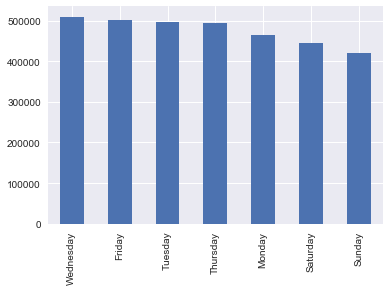

In [11]:
## what's the most common weekday?
bikes.start_day_name.value_counts().plot(kind='bar')

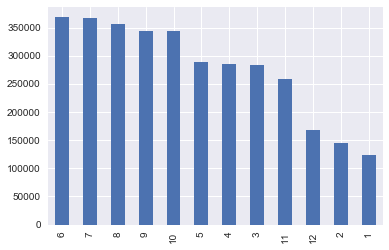

In [12]:
## What's the most common month?
bikes.start_month.value_counts().plot(kind='bar')

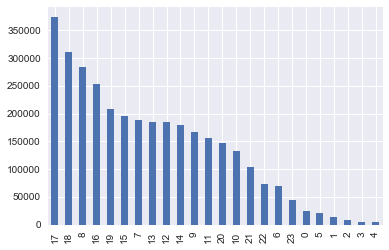

In [13]:
## What's the most common hour?
bikes.start_hour.value_counts().plot(kind='bar')

(array([  4.67560000e+05,   9.56446000e+05,   6.70996000e+05,
          4.29254000e+05,   2.78321000e+05,   1.63640000e+05,
          7.76280000e+04,   4.45640000e+04,   3.10080000e+04,
          2.55210000e+04,   2.13310000e+04,   1.82700000e+04,
          1.50010000e+04,   1.24690000e+04,   1.12710000e+04,
          1.02940000e+04,   9.60600000e+03,   8.53800000e+03,
          7.62900000e+03,   6.78500000e+03,   0.00000000e+00,
          5.27530000e+04,   7.86600000e+03,   2.21900000e+03,
          9.08000000e+02,   6.01000000e+02,   5.33000000e+02,
          4.88000000e+02,   4.87000000e+02]),
 array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
         65,  70,  75,  80,  85,  90,  95, 100, 100, 200, 300, 400, 500,
        600, 700, 800, 900]),
 <a list of 29 Patch objects>)

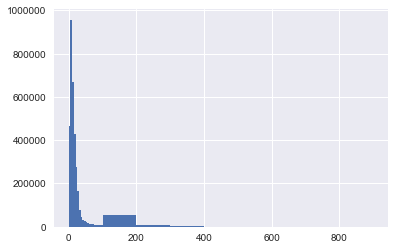

In [14]:
# Most of the trips are pretty short
bins = [x for x in range(0,101,5)] + [x for x in range(100,1000,100)]
plt.hist(bikes.trip_time, bins = bins)

In [15]:
## how many bikes are there an what's the median and mean number of trips on each?
print 'the Mean number of trips on each bike is {:.2f}'.format(bikes['Bike number'].value_counts().mean())
print 'the Median number of trips on each bike is {:.2f}'.format(bikes['Bike number'].value_counts().median())
print 'There are {} unique bikes'.format(bikes['Bike number'].nunique())

the Mean number of trips on each bike is 749.17
the Median number of trips on each bike is 802.00
There are 4450 unique bikes


(array([ 225.,  190.,  296.,  471.,  705.,  874.,  984.,  574.,  119.,   12.]),
 array([  1.00000000e+00,   1.48700000e+02,   2.96400000e+02,
          4.44100000e+02,   5.91800000e+02,   7.39500000e+02,
          8.87200000e+02,   1.03490000e+03,   1.18260000e+03,
          1.33030000e+03,   1.47800000e+03]),
 <a list of 10 Patch objects>)

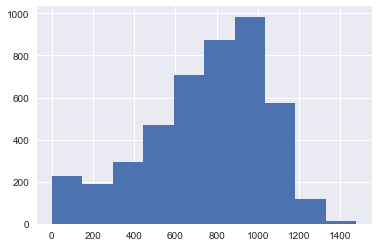

In [16]:
## histogram of rides
plt.hist(bikes['Bike number'].value_counts())

In [17]:
print bikes['Account type'].isnull().sum()
print bikes['Member Type'].isnull().sum()
bikes['Type']=bikes['Member Type'].fillna(bikes['Account type'])
bikes.Type.value_counts()

2391454
942332


Registered    2601521
Casual         732265
Name: Type, dtype: int64

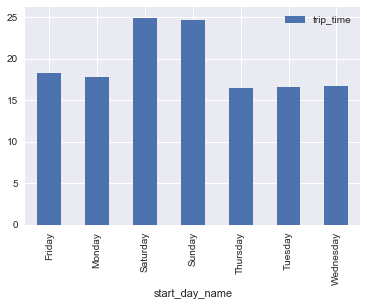

In [18]:
bikes.groupby('start_day_name')['Type','trip_time'].mean().plot(kind='bar')

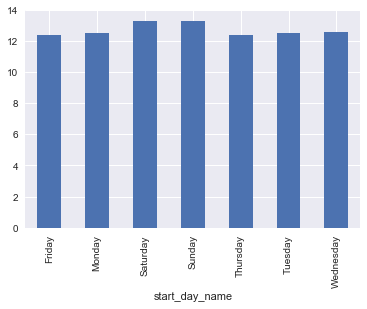

In [19]:
bikes[bikes.Type=='Registered'].groupby('start_day_name').trip_time.mean().plot(kind='bar')

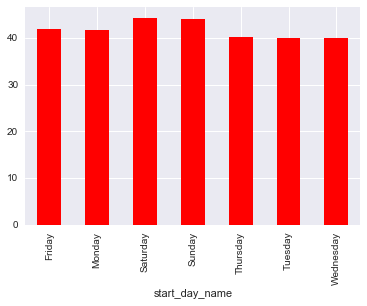

In [20]:
bikes[bikes.Type=='Casual'].groupby('start_day_name').trip_time.mean().plot(kind='bar', color='r')

In [21]:
print bikes.groupby('Type').trip_time.mean()
print bikes.groupby('Type').trip_time.count()

Type
Casual        42.303157
Registered    12.660977
Name: trip_time, dtype: float64
Type
Casual         732265
Registered    2601521
Name: trip_time, dtype: int64


In [924]:
## making a dictionary of the 4 closest stations for each station
start_time =time.time()
closest={}
for x in stations_list.index:
    find = pd.Series(stations_list.loc[x,cols])
    closest[x] = [y[-5:] for y in find.sort_values()[1:5].index]

end_time =time.time()
print str(end_time -start_time) + ' seconds'

0.732957839966 seconds


In [ ]:
# weather data
# https://darksky.net/forecast/38.8951,-77.0364/us12/en